# 1. Stable Diffusion Experiment

**Install required packages**

In [1]:
!pip install -q diffusers scipy transformers

**Import required packages**

In [2]:
import os
import re
import math
import random

import torch
import matplotlib.pyplot as plt

from torch import autocast
from diffusers import StableDiffusionPipeline

## 1.1 Login through huggingface cli

1. Create your (`read`) token over at: [https://huggingface.co/settings/tokens](https://huggingface.co/settings/tokens).
2. Set default credential helper for hugging face using: `git config --global credential.helper store`
3. Login to the huggingface cli using: `huggingface-cli login`

In [3]:
!git config --global credential.helper store

In [4]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token


## 1.2 Define model constants

This section is used to define constants for the model such as: `id`, `revision`, `gpu_device`, `gpu_low_vram`, `img_width`, `img_height`, `img_directory`.

In [5]:
STABLE_DIFFUSION_MODEL_ID = "CompVis/stable-diffusion-v1-4"
STABLE_DIFFUSION_MODEL_REV = "fp16"

STABLE_DIFFUSION_GPU_DEVICE = "cuda"
STABLE_DIFFUSION_GPU_LOW_VRAM = False

STABLE_DIFFUSION_IMG_WIDTH = 512
STABLE_DIFFUSION_IMG_HEIGHT = 512
STABLE_DIFFUSION_IMG_DIRECTORY = "./data"

## 1.3 Create model pipeline

Create the stable diffusion pipeline using the pretrained weights from [huggingface.co](https://huggingface.co/CompVis/stable-diffusion-v1-4).

In [6]:
stable_diffusion_pipeline = StableDiffusionPipeline.from_pretrained(
    STABLE_DIFFUSION_MODEL_ID,
    revision=STABLE_DIFFUSION_MODEL_REV,
    torch_dtype=torch.float16 if STABLE_DIFFUSION_GPU_LOW_VRAM else torch.float32,
    use_auth_token=True,
)

stable_diffusion_pipeline = stable_diffusion_pipeline.to(STABLE_DIFFUSION_GPU_DEVICE)

{'trained_betas'} was not found in config. Values will be initialized to default values.
ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


## 1.4 Create inference functions

Create the functions to run inference using stable diffusion. The `run_inference()` function can be used to generate multiple images using a single prompt, generating multiple images for the same prompt is achieved by using different random seeds.

In [7]:
def run_inference(
    pipeline,
    prompt,
    num_images=1,
    num_inference_steps=50,
    guidance_scale=7.5,
    enable_save=False,
):
    images = []
    seeds = []
    prompt_dir = re.sub(r"\W+", "_", prompt)
    image_dir = f"{STABLE_DIFFUSION_IMG_DIRECTORY}/{prompt_dir}/"

    if enable_save:
        try:
            os.makedirs(os.path.dirname(image_dir))
        except OSError:
            pass

    for idx in range(num_images):
        # Generate random seed
        seed = random.randint(0, 10000)

        # Set random seed
        generator = torch.Generator(STABLE_DIFFUSION_GPU_DEVICE).manual_seed(seed)

        # Generate images
        with autocast(STABLE_DIFFUSION_GPU_DEVICE):
            image = pipeline(
                prompt,
                width=STABLE_DIFFUSION_IMG_WIDTH,
                height=STABLE_DIFFUSION_IMG_HEIGHT,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
            ).images[0]

            images.append(image)
            seeds.append(seed)

            if enable_save:
                image.save(image_dir + f"img_{idx}_{seed}.png")

    return images, seeds

## 1.5 Create plot functions

Create the functions to plot the images generated by stable diffusion.

In [8]:
def plot_images(prompt, images, seeds, figsize=(24, 12)):
    fig = plt.figure(figsize=figsize)
    num_columns = 4
    num_rows = math.ceil(len(images)/num_columns)

    for idx, (image, seed) in enumerate(zip(images, seeds)):
        # Add plot to figure
        fig.add_subplot(num_rows, num_columns, idx+1)

        # Plot image
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"index: {idx}, seed: {seed}")

    fig.suptitle(f"prompt: {prompt}", fontsize=16, fontweight="bold")

## 1.6 Run inference

In [9]:
prompt = "a painting of a building in the middle of a city in the style of dali"

images, seeds = run_inference(
    stable_diffusion_pipeline,
    prompt,
    num_images=8,
    num_inference_steps=75,
    guidance_scale=7.5,
    enable_save=True,
)

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

## 1.7 Show images

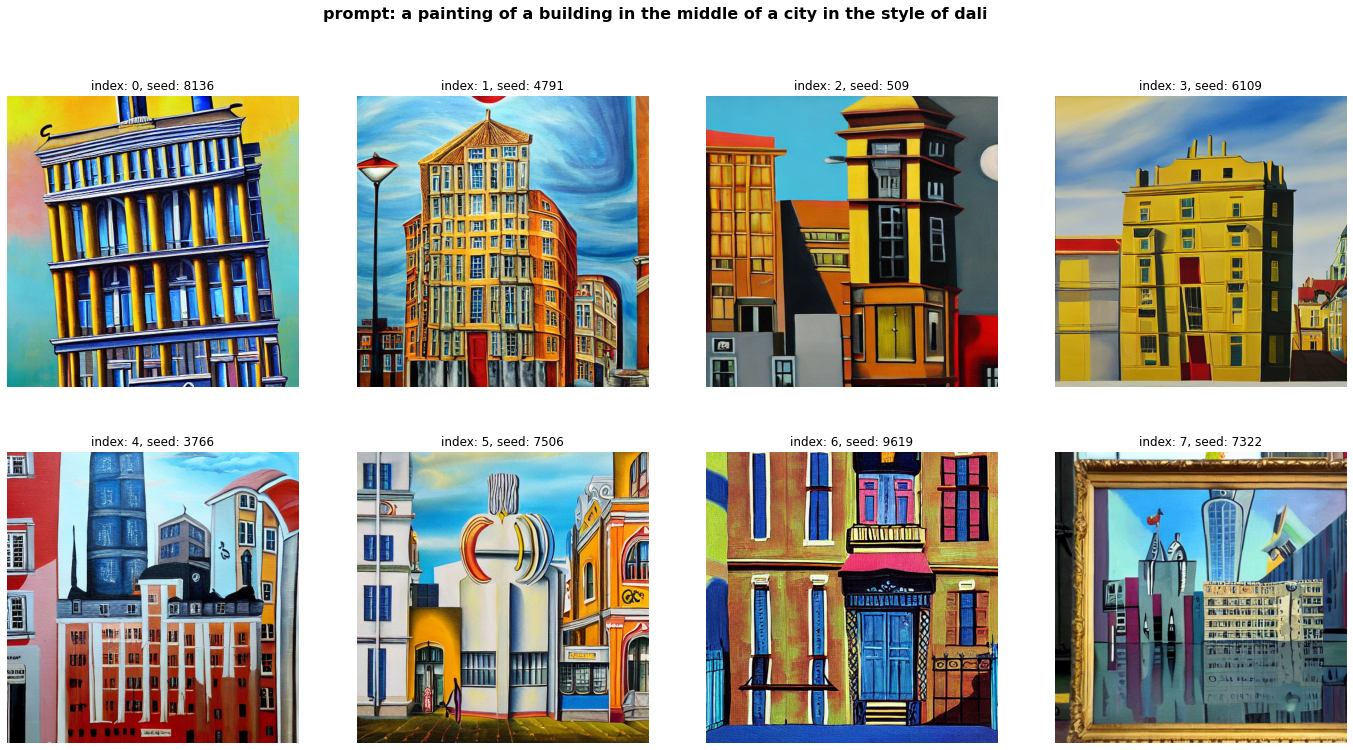

In [10]:
plot_images(
    prompt,
    images,
    seeds,
    figsize=(24, 12),
)